# Project 4: Reinforcement Learning
### Train a Smartcab How to Drive
<sub>Uirá Caiado. Jul 7, 2016<sub>

#### Abstract

*A smartcab is a self-driving car from the not-so-distant future that ferries people from one arbitrary location to another. In this project, I will design the AI driving agent for the smartcab using reinforcement learning. This [area of machine learning](https://en.wikipedia.org/wiki/Reinforcement_learning) is inspired by behaviorist psychology and consists in training the agent by reward and punishment without needing to specify how the task is to be achieved. The agent should learn an optimal policy for driving on city roads, obeying traffic rules correctly, and trying to reach the destination within a goal time.*


## 1. Introduction

In this section, I will present a brief introduction to reinforcement learning and to the problem addressed by this project.


### 1.1. Reinforcement Learning

As explained by \cite{Mohri_2012}, reinforcement learning is the study of planning and learning in a scenario where a learner (or agent) actively interacts with the environment to achieve a particular goal. The achievement of the agent's goal is typically measured by the reward he receives from the environment and which he seeks to maximize.

\cite{Kaelbling_1996} state that the most significant difference between reinforcement learning and supervised learning is that there is no presentation of input/output pairs. Instead, they explained that after choosing an action, the agent is told the immediate reward and the following state, but is not told which action would have been in its best long-term interests. It is necessary for the agent to gather useful experience about the possible system states, actions, transitions and rewards actively to act optimally.

Defining a general formulation of the problem based on a Markov Decision Process (MDP), as proposed by \cite{Mitchell}, the agent can perceive a set $S$ os distinct states of its environment and has a set $A$ of actions that it can perform. So, at each discrete time step $t$, the agent senses the current state $s_t$ and choose to take an action $a_t$. The environment responds by providing the agent a reward $r_t=r(s_t, a_t)$ and by producing the succeeding state $s_{t+1}=\delta(s_t, a_t)$. The functions $r$ and $\delta$ only depend on the current state and action (it is [memoryless](https://en.wikipedia.org/wiki/Markov_process)), are part of the environment and are not necessarily known to the agent.

The task of the agent is to learn a policy $\pi$ that maps each state to an action ($\pi: S \rightarrow A$), selecting its next action $a_t$ based solely on the current observed state $s_t$, that is $\pi(s_t)=a_t$. The optimal policy, or control strategy, is the one that produces the greatest possible cumulative reward over time. So, stating that:

$$V^{\pi}(s_t)= r_t + \gamma r_{t+1} + \gamma^2 r_{t+1} + ... = \sum_{i=0}^{\infty} \gamma^{i} r_{t+i}$$

Where $V^{\pi}(s_t)$ is also called the discounted cumulative reward and it represents the cumulative value achieved by following an policy $\pi$ from an initial state $s_t$ and $\gamma \in [0, 1]$ is a constant that determines the relative value of delayed versus immediate rewards. If we set $\gamma=0$, only immediate rewards is considered. As $\gamma \rightarrow 1$, future rewards are given greater emphasis relative to immediate reward. The optimal policy $\pi^{*}$ that will maximizes $V^{\pi}(s_t)$ for all states $s$ can be written as:

$$\pi^{*} = \underset{\pi}{\arg \max} \, V^{\pi} (s)\,\,\,\,\,, \,\, \forall s$$

As learning $\pi^{*}: S \rightarrow A$ directly is difficult because the available training data does not provide training examples of the form $(s, a)$, in the section 4 I will implement the Q-learning algorithm for estimating the optimal policy.


### 1.2. What Will Be Done

The goal of this project is to design the AI driving agent for the smartcab that operates in an idealized grid-like city.

The smartcab is able to sense whether the traffic light is green for its direction of movement and whether there is a car at the intersection on each of the incoming roadways (and which direction they are trying to go). In addition to this, each trip has an associated timer that counts down every time step. If the timer is at $0$ and the destination has not been reached, the trip is over, and a new one may start.

It should receive the inputs mentioned above at each time step t, and generate an output move, that consists on to stay put at the current intersection, move one block forward, one block left, or one block right (no backward movement).

The smartcab also should receive a reward for each successfully completed trip. A trip is considered “successfully completed” if the passenger is dropped off at the desired destination within a pre-specified time bound. It also gets a smaller reward for each correct move executed at an intersection. It gets a minor penalty for a wrong move and a larger penalty for violating traffic rules and/or causing an accident.

Based on the rewards and penalties it gets, the agent should learn an optimal policy for driving on city roads, obeying traffic rules correctly, and trying to reach the destination within a goal time.

## 2. Implement a Basic Driving Agent

In this section, I will implement a basic driving agent that accepts specified inputs ans produces a valid output.

```
Udacity:

Implement the basic driving agent, which processes the following inputs at each time step:

Next waypoint location, relative to its current location and heading, Intersection state (traffic light and presence of cars), and, Current deadline value (time steps remaining), And produces some random move/action (None, 'forward', 'left', 'right'). Don’t try to implement the correct strategy! That’s exactly what your agent is supposed to learn.

Run this agent within the simulation environment with enforce_deadline set to False (see run function in agent.py), and observe how it performs. In this mode, the agent is given unlimited time to reach the destination. The current state, action taken by your agent and reward/penalty earned are shown in the simulator.

In your report, mention what you see in the agent’s behavior. Does it eventually make it to the target location?


It is asked to:

- Agent accepts inputs: Student is able to implement the desired interface to the agent that accepts specified inputs.
- Produces a valid output: The driving agent produces a valid output (one of None, ‘forward’, ‘left’, ‘right’) in response to the inputs.
- Runs in simulator: The driving agent runs in the simulator without errors. Rewards and penalties do not matter - it’s okay for the agent to make mistakes.
```


### 2.1. My Grid-Like World

Let's start by testing the output produced by my current *world*, that will be used to analyze the results of this project. This *world* is a grid-like city, with roads going North-South and East-West. Other vehicles may be present on the streets, but no pedestrians. There is a traffic light at each intersection that can be in one of two states: North-South open or East-West open. US right-of-way rules apply: On a green light, you can turn left only if there is no oncoming traffic at the intersection coming straight. On a red light, you can turn right if there is no oncoming traffic turning left or traffic from the left going straight.

We are told to assume that a higher-level planner assigns a route to the smartcab, splitting it into waypoints at each intersection. The time in this world is quantized and at any instant, the smartcab is at some intersection. Therefore, the next waypoint is always either one block straight ahead, one block left, one block right, one block back or exactly there (reached the destination). Below is a sample of the log file generated by the simulator.

In [3]:
import random
from smartcab.environment import Agent, Environment
from smartcab.planner import RoutePlanner
from smartcab.simulator import Simulator
import smartcab.agent as agent; reload(agent);

In [16]:
e = Environment()  # create environment (also adds some dummy traffic)
a = e.create_agent(agent.LearningAgent)  # create agent
e.set_primary_agent(a, enforce_deadline=True)  # specify agent to track
sim = Simulator(e, update_delay=0.5, display=False)

In [17]:
# this test was performed before I implement the codes
sim.run(n_trials=1)

Simulator.run(): Trial 0
2016-07-16 16:29:32,947;Environment.reset(): Trial set up with start = (5, 2), destination = (2, 4), deadline = 25
2016-07-16 16:29:32,960;RoutePlanner.route_to(): destination = (2, 4)
2016-07-16 16:29:33,466;LearningAgent.update(): deadline = 25, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:33,966;LearningAgent.update(): deadline = 24, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:34,466;LearningAgent.update(): deadline = 23, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:34,966;LearningAgent.update(): deadline = 22, inputs = {'light': 'red', 'oncoming': None, 'right': 'forward', 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:35,466;LearningAgent.update(): deadline = 21, inputs = {'light': 'green', 'oncoming': None, 'right': 'forwar

### 2.3. The Basic Agent

As mentioned before, I am going to implement a smartcab that processes the following inputs at each time step:

- *Next waypoint location*: about its current position and heading
- *Intersection state*: traffic light and presence of cars
- *Current deadline value*: time steps remaining

For the purposes of this project, the first implementation of the agent should produce just some random move at each time $t$, such that $a_t \in (None,\, forward,\, left,\, right)$. I will not implement the correct strategy because it is precisely what my agent is supposed to learn. Below I am going to simulate $99$ different trials with the `enforce_deadline` set to False and will save the logs produced by the agent to observe how it performs. In this mode, the agent is given unlimited time to reach the destination.

In [1]:
s_fname = 'log/sim_Mon_Jul_18_003801_2016.txt'

with open(s_fname) as fr:
    i_trial = None
    i_fail = 0
    i_success = 0
    i_reached = 0
    l_last = []
    i_last_step = 0
    i_that_time = 0
    d_count = {'forward': 0, 'left': 0, 'right': 0, 'None': 0}
    for idx, row in enumerate(fr):
        s_aux = row.strip().split(';')[1]
        if 'LearningAgent.update' in s_aux:
            i_last_step = int(s_aux.split(',')[0].split('=')[1].strip())
            s_action = s_aux.split('action = ')[1].split(',')[0]
            d_count[s_action] += 1
        elif 'Environment.reset' in s_aux:
            if not i_trial:
                i_trial = 1
                i_initial_dealline = int(s_aux.split('deadline = ')[1])
            else:
                i_trial += 1
                l_last.append({'steps': i_initial_dealline - i_last_step,
                               'success': i_that_time})
                i_initial_dealline = int(s_aux.split('deadline = ')[1])
        elif 'Environment.step' in s_aux:
            i_fail += 1
            i_that_time = 0
        elif 'Environment.act' in s_aux:
            if i_last_step >=0:
                i_success += 1
            i_reached += 1
            i_that_time = 1

print "Number of Trials: {}".format(i_trial-1)
print "Times that the agent reached the target location: {}".format(i_reached-1)
print "Times the agent reached the hard deadline: {}".format(i_fail-1)
print "Times the agent SUCCESSFULLY reached the target location: {}".format(i_success-1)
print "Counting of moves made:\n{}".format(d_count)

Number of Trials: 99
Times that the agent reached the target location: 68
Times the agent reached the hard deadline: 31
Times the agent SUCCESSFULLY reached the target location: 20
Counting of moves made:
{'forward': 2018, 'None': 2085, 'right': 2035, 'left': 2094}


As can be seen above, even using just random moves, the agent still was able to reach the target destination roughly $20%$ of the trials at the deadline stipulated by the Planner. If we considering all the times it reached the location, it was able to complete the route almost $70%$ of the trials. Now, I am going to produce same basic statistics about the times that it reached the target location.

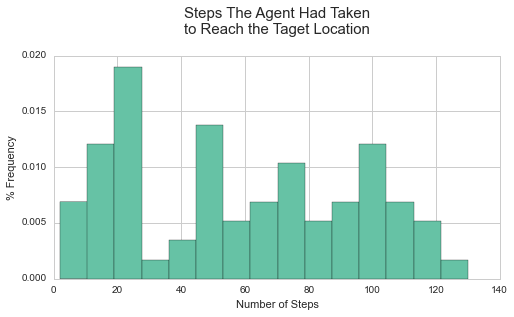

In [5]:
import pandas as pd
df_last = pd.DataFrame(l_last)
ax = (df_last.ix[df_last.success==1, 'steps']).hist(bins=15, normed=True)
ax.set_title("Steps The Agent Had Taken\nto Reach the Taget Location\n", fontsize=15);
ax.set_ylabel("% Frequency")
ax.set_xlabel("Number of Steps");

In [6]:
df_count = pd.DataFrame(df_last.ix[df_last.success==1, 'steps'])
df_count.columns = ["Number Of Steps"]
df_count.describe()

,Number Of Steps
count,68.00000
mean,59.00000
std,36.06048
min,2.00000
25%,23.75000
50%,60.00000
75%,91.00000
max,130.00000


It took 59 steps on average, and the variation was huge. The agent has taken from 2 steps to 130 to finish the route. In the next sections, I will try to improve that.

## 3. Identify and Update State

In this section, ...

```
Udacity:

It is asked to:

- Reasonable states identified: Student has identified states that model the driving agent and environment, along with a sound justification. Justify why you picked these set of states, and how they model the agent and its environment.
-  Agent updates state: The driving agent updates its state when running, based on current input. The exact state does not matter, and need not be correlated with inputs, but it should change during a run.
```

*From foruns: https://discussions.udacity.com/t/lost-in-project-4/167421/7*

*This is where you make the choice of how the agent represents the state internally. It could simply be a tuple of (inputs, deadline, next_waypoint) or it could be something else, something smaller, but not so over-engineered that the agent doesn't have much to learn. This was feedback I received from my first submission, so I am now in the process of testing out the agent with the full tuple of inputs. State space this way is quite large, resulting in slower convergence, making the task of meeting specifications after 100 trials quite challenging.*

## 4. Implement Q-Learning

In this section, ...

```
Udacity:

It is asked to:

- Agent updates Q-values: The driving agent updates a table/mapping of Q-values correctly, implementing the Q-Learning algorithm.
- Picks the best action: Given the current set of Q-values for a state, it picks the best available action.
- Changes in behavior explained: Student has reported the changes in behavior observed, and provided a reasonable explanation for them. What changes do you notice in the agent’s behavior?
```

https://discussions.udacity.com/t/how-often-do-you-explore-or-how-often-should-you-exploit/42812/3

## 5. Enhance the Driving Agent

In this section, ...

```
Udacity:

It is asked to:

- Agent learns a feasible policy within 100 trials: The driving agent is able to consistently reach the destination within allotted time, with net reward remaining positive.
- Improvements reported: Specific improvements made by the student beyond the basic Q-Learning implementation have been reported, including at least one parameter that was tuned along with the values tested. The corresponding results for each value are also reported.
- Final agent performance discussed: A description is provided of what an ideal or optimal policy would be. The performance of the final driving agent is discussed and compared to how close it is to learning the stated optimal policy. Report what changes you made to your basic implementation of Q-Learning to achieve the final version of the agent. How well does it perform? Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties?
```

## 6. Conclusion


bla bla bla

## 7. Reflection


bla bla bla

*Style notebook and change matplotlib defaults*

In [3]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [4]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))